#Distribution of Transaction Amounts and Amount Bins

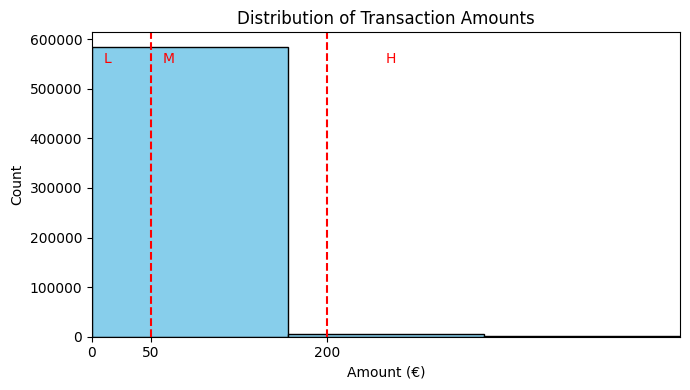

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('bs140513_032310.csv')
amount_bins = [0, 50, 200, float("inf")]
amount_labels = ['L', 'M', 'H']
df['amt_bin'] = pd.cut(df['amount'], bins=amount_bins, labels=amount_labels, right=False)

plt.figure(figsize=(7,4))
plt.hist(df['amount'], bins=50, color='skyblue', edgecolor='black')
for x in amount_bins[1:-1]:
    plt.axvline(x, color='red', linestyle='--')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount (€)')
plt.ylabel('Count')
plt.xticks([0, 50, 200, 2000, 10000])
plt.text(10, plt.ylim()[1]*0.9, 'L', color='red')
plt.text(60, plt.ylim()[1]*0.9, 'M', color='red')
plt.text(250, plt.ylim()[1]*0.9, 'H', color='red')
plt.xlim(0, 500)         # <<== You can safely set this here
plt.tight_layout()
plt.show()


#Distribution of Transactions by Time-of-Day Bin

tod_bin
N     14872
M     11053
E         0
N2        0
Name: count, dtype: int64


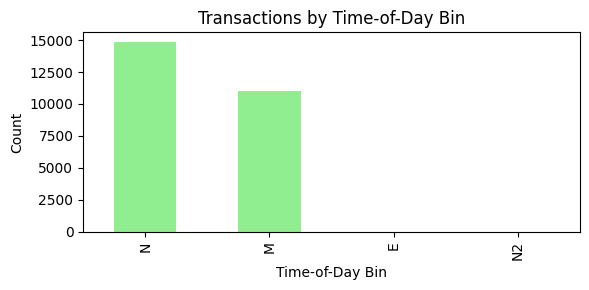

In [ ]:
tod_bins = [0, 6, 12, 18, 24]
tod_labels = ['N', 'M', 'E', 'N2']
df['hour'] = df['step'] % 24
df['tod_bin'] = pd.cut(df['hour'], bins=tod_bins, labels=tod_labels, right=False, include_lowest=True)
print(df['tod_bin'].value_counts())


plt.figure(figsize=(6,3))
df['tod_bin'].value_counts().loc[tod_labels].plot(kind='bar', color='lightgreen')
plt.title('Transactions by Time-of-Day Bin')
plt.xlabel('Time-of-Day Bin')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


#Symbol Alphabet Size

In [ ]:
df['category'] = df['category'].str.strip(" '")
def cat_abbr(cat): return cat.split('_')[-1][:3] if cat.startswith('es_') else cat[:3]
df['symbol'] = df['category'].apply(cat_abbr) + '_' + df['amt_bin'].astype(str) + '_' + df['tod_bin'].astype(str)

print("Number of unique symbols:", df['symbol'].nunique())
print("Example symbols:", df['symbol'].unique()[:10])


Number of unique symbols: 38
Example symbols: ['tra_L_N' 'hea_M_N' 'oth_M_N' 'tra_M_N' 'foo_L_N' 'hea_L_N' 'hea_H_N'
 'hot_M_N' 'bar_L_N' 'tec_M_N']


#Example Sequence for a Random Customer

In [ ]:
import random
sample_customer = random.choice(df['customer'].unique())
seq = df[df['customer']==sample_customer].sort_values('step')['symbol'].tolist()
print("Customer ID:", sample_customer)
print("Symbolic sequence (first 20 events):\n", seq[:20])


Customer ID: 'C1838948302'
Symbolic sequence (first 20 events):
 ['hot_L_N', 'tra_L_N', 'tra_L_N', 'tra_L_N']


#Pattern Growth Illustration

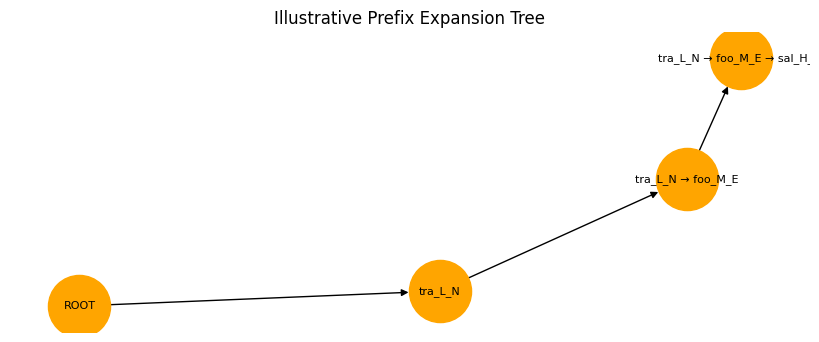

In [ ]:
import networkx as nx

# Small illustrative example
patterns = [('tra_L_N',), ('tra_L_N', 'foo_M_E'), ('tra_L_N', 'foo_M_E', 'sal_H_M')]
G = nx.DiGraph()
G.add_edge('ROOT', 'tra_L_N')
G.add_edge('tra_L_N', 'tra_L_N → foo_M_E')
G.add_edge('tra_L_N → foo_M_E', 'tra_L_N → foo_M_E → sal_H_M')

plt.figure(figsize=(8,3))
pos = nx.spring_layout(G, seed=1)
nx.draw(G, pos, with_labels=True, node_color='orange', node_size=2000, font_size=8, arrows=True)
plt.title('Illustrative Prefix Expansion Tree')
plt.axis('off')
plt.show()


In [ ]:
import pandas as pd, numpy as np, itertools, math, time
from collections import defaultdict

# --- Step 1: Load & Abstract Data ---
df = pd.read_csv('/content/bs140513_032310.csv')
for col in ['customer', 'category']:
    df[col] = df[col].str.strip(" '")
amount_bins = [0, 50, 200, float("inf")]
amount_labels = ['L', 'M', 'H']
df['amt_bin'] = pd.cut(df['amount'], bins=amount_bins, labels=amount_labels, right=False)
df['hour'] = df['step'] % 24
tod_bins = [0, 6, 12, 18, 24]
tod_labels = ['N', 'M', 'E', 'N2']
df['tod_bin'] = pd.cut(df['hour'], bins=tod_bins, labels=tod_labels, right=False, include_lowest=True)
def cat_abbr(cat): return cat.split('_')[-1][:3] if cat.startswith('es_') else cat[:3]
df['symbol'] = df['category'].apply(cat_abbr) + '_' + df['amt_bin'].astype(str) + '_' + df['tod_bin'].astype(str)

In [ ]:
# --- Step 2: Sequence DB (one list per customer) ---
seq_db = (df.sort_values(['customer', 'step'])
            .groupby('customer')['symbol']
            .apply(list)
            .tolist())
n_seqs = len(seq_db)
print("Number of sequences (customers):", n_seqs)

Number of sequences (customers): 4105


In [ ]:

# --- Step 3: Mining (Unique Support Counting) ---
minsup_ratio = 0.01
minsup = math.ceil(minsup_ratio * n_seqs)
MAXLEN = 3

def unique_support_closed_patterns(seqs, maxlen, minsup):
    """Counts support only once per sequence and finds closed patterns (len ≤ maxlen)."""
    freq = [defaultdict(set) for _ in range(maxlen + 1)]
    for sid, seq in enumerate(seqs):
        # For each pattern, only add once per sequence
        seen = [set() for _ in range(maxlen + 1)]
        for L in range(1, maxlen + 1):
            for idxs in itertools.combinations(range(len(seq)), L):
                subseq = tuple(seq[i] for i in idxs)
                if subseq not in seen[L]:
                    freq[L][subseq].add(sid)
                    seen[L].add(subseq)
    # Keep only frequent (support = num unique seqs)
    freq = [{k: v for k, v in d.items() if len(v) >= minsup} for d in freq]
    # Closedness: a pattern is closed if no extension has identical support
    closed = {}
    for L in range(1, maxlen):
        for pat, seq_ids in freq[L].items():
            is_closed = True
            for s in set(df['symbol']):
                superpat = pat + (s,)
                if superpat in freq[L+1] and freq[L+1][superpat] == seq_ids:
                    is_closed = False
                    break
            if is_closed:
                closed[pat] = len(seq_ids)
    closed.update({pat: len(seq_ids) for pat, seq_ids in freq[MAXLEN].items()})
    return closed

t0 = time.time()
closed = unique_support_closed_patterns(seq_db, MAXLEN, minsup)
print(f"Closed patterns (len ≤ {MAXLEN}): {len(closed)}  [computed in {time.time()-t0:.1f} s]")


Closed patterns (len ≤ 3): 16062  [computed in 144.3 s]


In [ ]:
# --- Step 4: Results ---
pat_df = pd.DataFrame([(" → ".join(p), sup) for p, sup in closed.items()],
                      columns=["pattern", "support"]).sort_values("support", ascending=False)
print("\nTop-15 Methodology-Compliant Closed Patterns:")
print(pat_df.head(15))


Top-15 Methodology-Compliant Closed Patterns:
                             pattern  support
7                            tra_L_N     3493
4                           tra_L_N2     3467
116              tra_L_N2 → tra_L_N2     3446
119               tra_L_N2 → tra_L_N     3438
10                           tra_L_E     3425
1518  tra_L_N2 → tra_L_N2 → tra_L_N2     3423
1521   tra_L_N2 → tra_L_N2 → tra_L_N     3420
134                tra_L_N → tra_L_N     3417
151               tra_L_E → tra_L_N2     3411
1667   tra_L_E → tra_L_N2 → tra_L_N2     3407
149                tra_L_E → tra_L_E     3406
1662    tra_L_E → tra_L_E → tra_L_N2     3397
152                tra_L_E → tra_L_N     3386
1668    tra_L_E → tra_L_N2 → tra_L_N     3386
1660     tra_L_E → tra_L_E → tra_L_E     3380


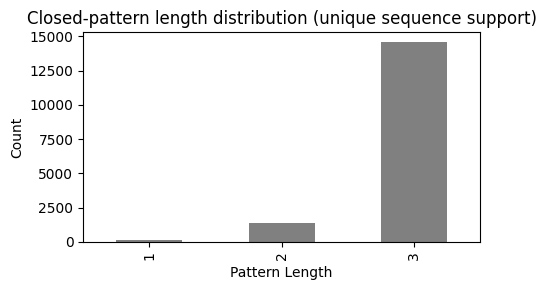

In [ ]:
# --- Step 5: Plot Pattern Length Distribution ---
pat_df["length"] = pat_df["pattern"].str.count("→") + 1
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
pat_df["length"].value_counts().sort_index().plot(kind="bar", color="grey")
plt.title("Closed-pattern length distribution (unique sequence support)")
plt.ylabel("Count")
plt.xlabel("Pattern Length")
plt.tight_layout()
plt.show()

In [ ]:
# --- Step 6: Save ---
pat_df.to_csv("closed_patterns_banksim_methodology.csv", index=False)
print("\nAll methodology-compliant patterns written to closed_patterns_banksim_methodology.csv")



All methodology-compliant patterns written to closed_patterns_banksim_methodology.csv
